In [1]:
import pandas as pd
df = pd.read_csv("./Data/HilbertSortedPOIs.csv")
print(df)
TOTAL = len(df)+1
COL = df.columns

# maybe I should substract the mean of hilbert: not performance gain
# print(df.iloc[:,4].mean())
# df.iloc[:,4] = df.iloc[:,4] - df.iloc[:,4].mean()
# print(df)|

# maybe I should divide the variance of hilbert? 
df.iloc[:,4] = df.iloc[:,4] / df.iloc[:,4].var()
print(df)

# 用GAN 来做类似Rtree？

               x         y       x_       y_         hilbert    order  \
0       -54.9356  -67.6150   701288  1123850   2121205890180        0   
1       -54.7979  -68.3110   704042  1116890   2121429835144        1   
2       -54.8064  -68.3336   703872  1116664   2121430220778        2   
3       -54.8080  -68.3086   703840  1116914   2121430582030        3   
4       -54.8080  -68.3074   703840  1116926   2121430582270        4   
5       -54.8075  -68.3126   703850  1116874   2121430584456        5   
6       -54.8075  -68.3034   703850  1116966   2121430610552        6   
7       -54.8061  -68.3032   703878  1116968   2121430615254        7   
8       -54.8012  -68.3056   703976  1116944   2121430620010        8   
9       -54.8045  -68.3008   703910  1116992   2121430627990        9   
10      -54.8062  -68.2972   703876  1117028   2121430629408       10   
11      -54.8396  -68.3124   703208  1116876   2121430863034       11   
12      -53.7941  -67.7364   724118  1122636   2121

In [7]:
import numpy as np
print(np.any(np.isnan(df))) # should be false
print(np.all(np.isfinite(df))) # should be true
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
print(scaler.fit(df.iloc[:,0:5]))
print(scaler.mean_)
df.iloc[:,0:5]=scaler.transform(df.iloc[:,0:5])
# print(df)
# print(df)
selected = [0,2,5]
print(df.iloc[selected,:])

False
True
StandardScaler(copy=True, with_mean=True, with_std=True)
[  4.59630433e-16   1.08032794e-16   2.26279598e-16  -1.59495689e-16
  -1.34353511e-15]
          x         y        x_        y_   hilbert  order  prediction
0 -2.977709 -0.901938 -2.977708 -0.901938 -2.103736      0           0
2 -2.972607 -0.910414 -2.972606 -0.910414 -2.103674      2           0
5 -2.972650 -0.910167 -2.972650 -0.910166 -2.103674      5           0


In [3]:
# from sklearn import ensemble
# lr = ensemble.GradientBoostingRegressor()
# train_x = df.iloc[:,0:5]
# train_y = df.iloc[:,5]
# start_time=time.time()
# lr.fit(train_x,train_y)
# elapsed_time = time.time() - start_time
# print(elapsed_time)

# start_time=time.time()
# predicted = lr.predict(train_x)
# elapsed_time = time.time() - start_time
# print(elapsed_time)

# import matplotlib.pyplot as plt
# fig, ax = plt.subplots()
# ax.scatter(train_y, predicted, edgecolors=(0, 0, 0))
# ax.plot([train_y.min(), train_y.max()], [train_y.min(), train_y.max()], 'k--', lw=4)
# ax.set_xlabel('Measured')
# ax.set_ylabel('Predicted')
# plt.show()

# from sklearn.metrics import explained_variance_score
# train_y=df.iloc[:,5]
# print(len(train_y))
# print(len(predicted))

# # 1- Var(Ytrue - Ypred)/Var(Ytrue)  best: 1  the lower the worse
# result = explained_variance_score(train_y, predicted)
# print(result)# calculate scan item amount

# ind = 0
# scan = 0
# totalscan = 0
# for i in range(len(df)):
#     ind = predicted[i]
#     scan = abs(ind-i) # distance to exact
#     totalscan += scan

# print(totalscan/len(df))

In [3]:
from sklearn import linear_model
from sklearn import neural_network
from sklearn import ensemble
import ipdb
import time
stages = [1,10,100]
index = []
data = []

start_time=time.time()

for i in range(len(stages)):
    temp = []
    for j in range(stages[i]):
        df_ = pd.DataFrame(columns=COL)
        temp.append(df_)
    data.append(temp)
    
data[0][0] = df
nodatacount = 0

for i in range(len(stages)):
    temp = []
    print("======stage:"+str(i)+"======")
    
    for j in range(stages[i]):
        print("model:"+str(j))
        if len(data[i][j]) == 0:
            nodatacount += 1
            data[i][j] = data[i][j-1]
            print(j)
        lr = linear_model.LinearRegression()
#         lr = linear_model.ElasticNet(max_iter=10000)
#         lr = linear_model.Lasso(max_iter=10000)
#         lr = ensemble.GradientBoostingRegressor()
#         lr = ensemble.AdaBoostRegressor()
#         if i == 0:
#             lr = neural_network.MLPRegressor(hidden_layer_sizes=(8, 2),max_iter=1000)
# #             lr = ensemble.GradientBoostingRegressor(n_estimators=500)
#         else:
#             lr = ensemble.GradientBoostingRegressor()
#         train_x = data[i][j].iloc[:,4].reshape(-1,1)
        train_x = data[i][j].iloc[:,0:5]
        train_y = data[i][j].iloc[:,5]
        lr.fit(train_x,train_y)
        temp.append(lr)
        # allocate data
        if i < len(stages)-1:
            predicted = lr.predict(train_x)
            for pi in range(len(predicted)): # do not change the prediction
                #print(item)
                if predicted[pi] < 0:
                    predicted[pi] = 0
                if predicted[pi] >= TOTAL:
                    predicted[pi] = TOTAL-1   
            ModelID = ((predicted/TOTAL)*stages[i+1]).astype(int)
            data[i][j].iloc[:,-1]=ModelID
#             if i == 1 and np.any(data[i][j]['prediction'] == 4):
#                 print(j)

            for k in range(stages[i+1]):
                data[i+1][k] = data[i+1][k].append(data[i][j].loc[data[i][j]['prediction'] == k])
    index.append(temp)

elapsed_time = time.time() - start_time
print(elapsed_time)
print(nodatacount)

======stage:0======
model:0
======stage:1======
model:0
model:1
model:2
model:3
model:4
model:5
model:6
model:7
model:8
model:9
======stage:2======
model:0
model:1
model:2
model:3
model:4
model:5
model:6
model:7
model:8
model:9
model:10
model:11
model:12
model:13
model:14
model:15
model:16
model:17
model:18
model:19
model:20
model:21
model:22
model:23
model:24
model:25
model:26
model:27
model:28
model:29
model:30
model:31
model:32
model:33
model:34
model:35
model:36
model:37
model:38
model:39
model:40
model:41
model:42
model:43
model:44
model:45
model:46
model:47
model:48
model:49
model:50
model:51
model:52
model:53
model:54
model:55
model:56
model:57
model:58
model:59
model:60
model:61
model:62
model:63
model:64
model:65
model:66
model:67
model:68
model:69
model:70
model:71
model:72
model:73
model:74
model:75
model:76
model:77
model:78
model:79
model:80
model:81
model:82
model:83
model:84
model:85
model:86
model:87
model:88
model:89
model:90
model:91
model:92
model:93
model:94
model:9

In [4]:
import numpy as np
# use the generated stage index for prediction
def predict_with_stage_model(model, data):
    totalSize = len(data)+1
    predicted_y = []
    tempy = 0
    for i in range(len(data)):
        modelIndex = 0
        for m in range(len(model)):
            tempy = model[m][modelIndex].predict(data.iloc[i,:].reshape(1,-1))
#             tempy = model[m][modelIndex].predict(data.iloc[i,])
            if tempy < 0:
                tempy = 0
            if tempy >= totalSize:
                tempy = totalSize-1
            if m < len(model)-1:
                modelIndex = int((tempy/totalSize)*len(model[m+1]))
                
        predicted_y.append(tempy)
        
    return predicted_y

D:\anaconda\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.


400.22149991989136


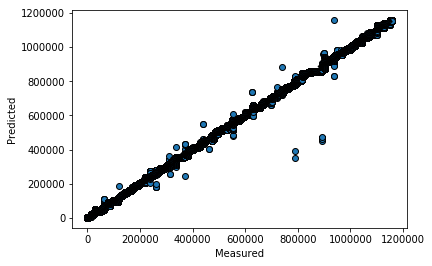

In [5]:
import matplotlib.pyplot as plt
import time

train_x=df.iloc[:,0:5]
# train_x=df.iloc[:,4]
train_y=df.iloc[:,5]

start_time=time.time()
predicted_y = predict_with_stage_model(index, train_x)
elapsed_time = time.time() - start_time
print(elapsed_time)

fig, ax = plt.subplots()
ax.scatter(train_y, predicted_y, edgecolors=(0, 0, 0))
ax.plot([train_y.min(), train_y.max()], [train_y.min(), train_y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [6]:
# estimate the result
from sklearn.metrics import explained_variance_score
train_y=df.iloc[:,5]
print(len(train_y))
print(len(predicted_y))

# 1- Var(Ytrue - Ypred)/Var(Ytrue)  best: 1  the lower the worse
result = explained_variance_score(train_y, predicted_y)
print(result)# calculate scan item amount

ind = 0
scan = 0
totalscan = 0
for i in range(len(df)):
    ind = predicted_y[i]
    scan = abs(ind-i) # distance to exact
    totalscan += scan

print(totalscan/len(df))

1157570
1157570
0.999638666972
[ 3996.2736762]
